In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# %matplotlib notebook

In [2]:
df= pd.read_csv(r'D:/Data/secret/MIMIC_MY/final_sepsis.csv')

In [5]:
def missing_dect(df):
    '''统计每个变量的缺失数据的数量，编量名称的DataFrame'''
    cols={'feature_no':[],'Variables':[],'null_num':[],'null_rate(%)':[]}

    for e, c in enumerate(df.columns):
#         if sum(pd.isnull(df[c]))!=0:
            cols['feature_no'].append(e)
            cols['Variables'].append(c)
            cols['null_num'].append(sum(pd.isnull(df[c])))
            cols['null_rate(%)'].append(sum(pd.isnull(df[c]))/len(df[c]))
    return pd.DataFrame(cols).sort_values(ascending=False,by='null_num')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
from tqdm import tqdm
import json

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, auc
from sklearn.metrics import roc_curve

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination


In [2]:
def read_data(file='',
              file_path=r'D:/Data/secret/MIMIC_MY/',
              file_name='sepsis_del_missing.csv',
              index_colol=None):
    if file == '':
        file = os.path.join(file_path, file_name)
    if file_name[-4:] == '.csv':
        dat = pd.read_csv(file)
    if file_name[-4:] == 'xlsx':
        dat = pd.read_excel(file)

    print('readIN_shape %s' % str(dat.shape))

    dropTime = [x for x in dat.columns if 'time' in x]
    dropId = [x for x in dat.columns if '_id' in x]

    dat.drop(dropTime, axis=1, inplace=True)
    print('drop_Time_shape %s' % str(dat.shape))
    dat.drop(dropId, axis=1, inplace=True)
    print('drop_ID_shape %s' % str(dat.shape))

    return dat


def missing_dect(df, missingRate=0.1, method='mode'):
    '''统计每个变量的缺失数据的数量，编量名称的DataFrame'''
    cols = {
        'feature_no': [],
        'Variables': [],
        'null_num': [],
        'null_rate(%)': []
    }
    for e, c in enumerate(df.columns):
        cols['feature_no'].append(e)
        cols['Variables'].append(c)
        cols['null_num'].append(sum(pd.isnull(dat[c])))
        cols['null_rate(%)'].append(sum(pd.isnull(df[c])) / len(df[c]))
    datMS = pd.DataFrame(cols)  # .sort_values(ascending=False,by='null_num')

    dat_data = dat.loc[:, list(datMS['null_rate(%)'] < missingRate)]
    print('输入的形状%s' % str(dat_data.shape))
    print('==下面的特征因数据缺失率>%f而被删除==' % missingRate)
    print(datMS[datMS['null_rate(%)'] > missingRate]['Variables'])

    # 缺失值填补，
    if method == 'mode':
        # 采用众数填补
        print('=' * 20, '填补的缺失值数量', '=' * 20)
        for item in dat_data.columns:
            if dat_data.loc[:, item].isna().sum() > 0:
                print(item, dat_data.loc[:, item].isna().sum())
                dat_data.loc[:, item] = dat_data.loc[:, item].fillna(
                    dat_data.loc[:, item].mode()[0])  # 采用第一个众数填补缺失值
    return dat_data


def Boxing_Numeric(dat_data, cut=4):
    # 分箱
    DFBoxed = dat_data.copy()
    for var in DFBoxed.columns.values:
        if type(DFBoxed[var][0]) != str:
            if DFBoxed[var].mode()[0] not in [0, 1, 2, 3, 4,100]:  # 众数不为1,0，说明为连续变量
                DFBoxed[var] = pd.qcut(DFBoxed[var].tolist(),
                                       q=cut,duplicates="drop",
                                      labels = [x for x in range(cut)])  # 按照4分位数切分

    # 变量数值化
    dat_data = DFBoxed
    ch_dict = []
    for item in dat_data.columns:
        if type(dat_data[item][1]) == str : #or dat_data.age_mean.dtype == 'category':
            # 字符型变量，进行数值化操作
            unique_value = dat_data[item].unique().tolist()
            unique_value.sort()
            temp = [item]
            for k, v in enumerate(unique_value):
                temp.append([v, k])
            ch_dict.append(temp)
            dat_data[item] = dat_data[item].apply(
                lambda x: unique_value.index(x))
    #     print('=' * 20, '特征编码方案', '=' * 20)
    #     print(pd.DataFrame(ch_dict))
    # pd.DataFrame(ch_dict).to_csv(os.path.join(log_path, hour) + 'encoding.csv')

    return dat_data


def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)  # Only the first occurrence is returned.
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point



def PRF1(ytest, ypre, yproba,threshold=0.5):
    from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, roc_auc_score
    if threshold == 0.5:
        myA = accuracy_score(ytest, ypre)
        myP = precision_score(ytest, ypre)
        myR = recall_score(ytest, ypre)
        F1 = f1_score(ytest, ypre)
        auc = roc_auc_score(ytest, yproba)
        return myA, myP, myR, F1, auc
    else:
        myA = accuracy_score(ytest, [1 if x > threshold else 0 for x in yprob])
        myP = precision_score(ytest, [1 if x > threshold else 0 for x in yprob])
        myR = recall_score(ytest, [1 if x > threshold else 0 for x in yprob])
        F1 = f1_score(ytest, [1 if x > threshold else 0 for x in yprob])
        auc = roc_auc_score(ytest, yproba)
        return myA, myP, myR, F1, auc

    
    
def plot_ROC_kfold(tprs, opts, l):
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig = plt.figure(figsize=(12, 9), dpi=150)
    i = 0

    for tpr, opt in zip(tprs,opts):
        roc_auc = auc(mean_fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(mean_fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f, th = %0.2f)' % (i + 1, roc_auc,opt[0]))
        plt.plot(opt[1][0], opt[1][1], marker='o', color='r', alpha=0.3)
        i += 1

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2,
             alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC: %s' % l)
    plt.legend(loc="lower right")

#     plt.savefig(os.path.join(log_path, hour + l + '.pdf'), dpi=300)

    plt.show()
    
def MIC_selection(df,k=20):
    from sklearn.feature_selection import mutual_info_classif as MIC
    xDF = dat_data[dat_data.columns.difference([targetY])]
    yDF = dat_data[targetY]
    result=pd.DataFrame({'var':xDF.columns.tolist(),'MIC':MIC(xDF, yDF)}).sort_values(by='MIC',ascending=False)
#     result.reset_index().to_csv(os.path.join(log_path,hour+'MIC.csv'))
#     xDF[result.iloc[:k, 0].tolist()].join(yDF).to_csv(os.path.join(log_path,hour+'MIC_selection.csv'))
    return xDF[result.iloc[:k,0].tolist()], yDF

def plot_ROC_kmodel(kmodel):
    aucs = []
    tprs_mean =kmodel['TPR_MEAN']
    tprs_std =kmodel['TPR_STD']
    l=kmodel['L']
    mean_fpr = np.linspace(0, 1,100)
    fig = plt.figure(figsize=(12, 9), dpi=150)
    i = 0

    for mean_tpr, std_tpr, l in zip(tprs_mean,tprs_std,l):
        roc_auc = auc(mean_fpr, mean_tpr)
        aucs.append(roc_auc)
        plt.plot(mean_fpr, mean_tpr, lw=1, label=l+'(AUC = %0.2f)' % roc_auc)
        
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
        i += 1

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC: %s' % l)
    plt.legend(loc="lower right")

#     plt.savefig(os.path.join(log_path, hour + l + '.pdf'), dpi=300)

    plt.show()

In [3]:
fileName = 'final_sepsis.csv'
targetY = 'death_within_30_days'

filePath = r'D:\Data\secret\MIMIC_MY'  # Windows_file_path
# filePath=r'~/Documents/Data/secret/MIMIC_MY' #Mac_file_path

missingRate = 0.1
fold = 3

features_num=19
feature_cut=5

In [4]:
random_state = 233

# 读取删除缺失数据较多的特征之后的表
dat = read_data(file=os.path.join(filePath,'final_sepsis_del_missing.csv'))

# 进行缺失值探查，并且将缺失值较多的，并进行缺失值填补
dat = missing_dect(dat, missingRate=missingRate, method='mode')
dat_data = Boxing_Numeric(dat,cut=feature_cut)

readIN_shape (15642, 49)
drop_Time_shape (15642, 49)
drop_ID_shape (15642, 47)
输入的形状(15642, 47)
==下面的特征因数据缺失率>0.100000而被删除==
Series([], Name: Variables, dtype: object)
==================== 填补的缺失值数量 ====================


In [5]:
# 变量筛选
xDF,yDF=MIC_selection(dat_data,k=features_num)


# 划分测试集和训练集
skfolds = StratifiedKFold(n_splits=fold, shuffle=True, random_state=random_state)
KFold = skfolds.split(xDF, yDF)
kmodel={'TPR_MEAN':[],'TPR_STD':[],'OPTS':[],'L':[]}

In [6]:
import shap
from lightgbm import LGBMClassifier as LGBMC
from sklearn.metrics import mean_squared_error as MSE

df = xDF.join(yDF)
df.shape
xtrain, xtest, ytrain, ytest = train_test_split(xDF,yDF,test_size=0.2,random_state=random_state)

In [7]:
from xgboost import XGBClassifier as XGBC
from lightgbm import LGBMClassifier as LGBMC
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [72]:
model = LGBMC(num_leaves=31, 
                      learning_rate=0.05, 
                      n_estimators=20,
                      random_state=random_state).fit(np.array(xtrain), np.array(ytrain))
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(np.array(xtest))  # 传入特征矩阵X，计算SHAP值
    
shapDF=pd.DataFrame(shap_values[1],columns=xtest.columns.tolist())
sp=shapDF.apply(lambda x: abs(x)).mean().reset_index()
sp.columns=['var','LightGBM']
sp1=sp
sp1

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


,var,LightGBM
0,sapsii_prob_max,0.336452
1,urine_max,0.086746
2,antibiotic_num,0.255062
3,specimen_count,0.039919
4,aniongap_min,0.042833
5,aniongap_max,0.036191
6,bun_max,0.006326
7,bun_min,0.018380
8,creatinine_max,0.000999
9,inr_max,0.047167


In [9]:
model = XGBC(n_estimators =100,
                         random_state=random_state,
                         learning_rate=0.1,
                         booster='gbtree',
                         objective='reg:logistic',
                         silent=False).fit(np.array(xtrain), np.array(ytrain))
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(np.array(xtest))  # 传入特征矩阵X，计算SHAP值

shapDF=pd.DataFrame(shap_values,columns=xtest.columns.tolist())
sp=shapDF.apply(lambda x: abs(x)).mean().reset_index()
sp.columns=['var','XGBoost']
sp2=sp
sp2

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[20:08:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




ntree_limit is deprecated, use `iteration_range` or model slicing instead.


,var,XGBoost
0,sapsii_prob_max,0.513977
1,urine_max,0.322662
2,antibiotic_num,0.560615
3,specimen_count,0.097537
4,aniongap_min,0.158465
5,aniongap_max,0.104388
6,bun_max,0.049340
7,bun_min,0.157658
8,creatinine_max,0.114722
9,inr_max,0.170236


In [10]:
model = RandomForestClassifier(n_estimators=100,random_state=random_state).fit(np.array(xtrain), np.array(ytrain))
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(np.array(xtest))  # 传入特征矩阵X，计算SHAP值

shapDF=pd.DataFrame(shap_values[1],columns=xtest.columns.tolist())
sp=shapDF.apply(lambda x: abs(x)).mean().reset_index()
sp.columns=['var','RF']
sp3=sp
sp3

,var,RF
0,sapsii_prob_max,0.047583
1,urine_max,0.044574
2,antibiotic_num,0.044978
3,specimen_count,0.024005
4,aniongap_min,0.013277
5,aniongap_max,0.013671
6,bun_max,0.011255
7,bun_min,0.013913
8,creatinine_max,0.005441
9,inr_max,0.020033


In [ ]:
# ###########################这个运行超级慢#######################################
# model = svm.SVC(kernel='rbf',gamma='auto',C=1,probability=True).fit(np.array(xtrain), np.array(ytrain))
# explainer = shap.KernelExplainer(model.predict_proba, xtrain, link="logit")
# shap_values = explainer.shap_values(np.array(xtest))  # 传入特征矩阵X，计算SHAP值

# shapDF=pd.DataFrame(shap_values[1],columns=xtest.columns.tolist())
# sp=shapDF.apply(lambda x: abs(x)).mean().reset_index()
# sp.columns=['var','SVM']
# sp4=sp
# sp4

Using 12513 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/3129 [00:00<?, ?it/s]

In [70]:
shapValue=pd.merge(sp1,sp2,how='outer',on='var')
shapValue=pd.merge(shapValue,sp3,how='outer',on='var')
shapValue=shapValue.sort_values(by='XGBoost',ascending=True)
shapValue

,var,LightGBM,XGBoost,RF
16,bicarbonate_max,0.000826,0.042486,0.004992
6,bun_max,0.006326,0.049340,0.011255
10,bicarbonate_min,0.006373,0.056117,0.008651
11,creatinine_min,0.001923,0.061335,0.005020
17,chloride_min,0.007898,0.096986,0.008116
3,specimen_count,0.039919,0.097537,0.024005
5,aniongap_max,0.036191,0.104388,0.013671
12,sofa_score,0.009404,0.106146,0.010160
8,creatinine_max,0.000999,0.114722,0.005441
7,bun_min,0.018380,0.157658,0.013913


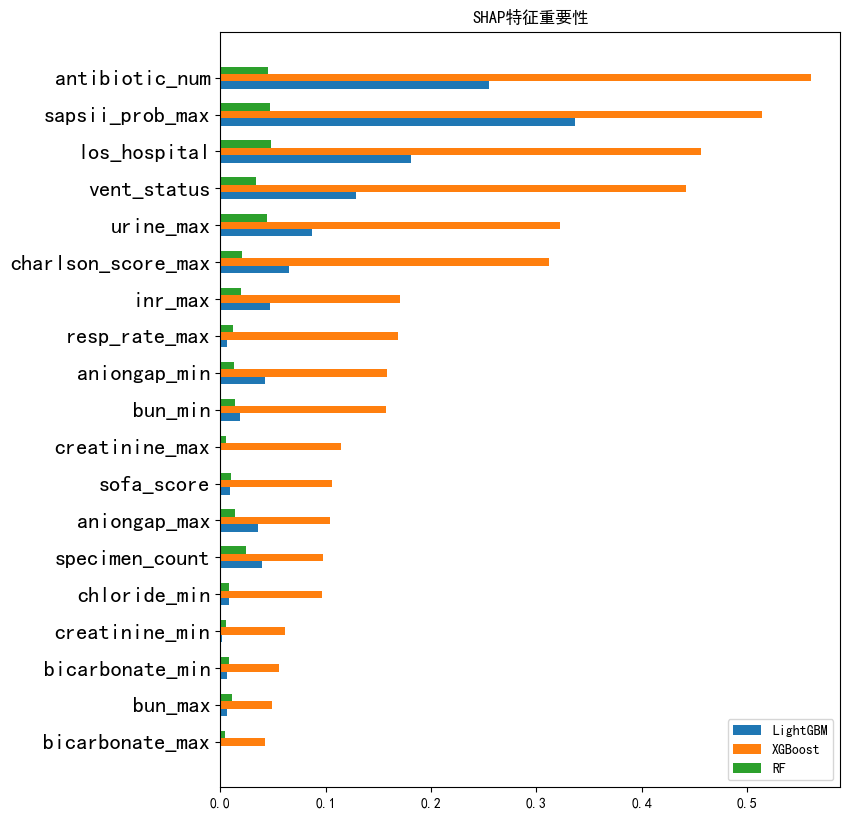

In [69]:
%matplotlib inline
bar_width = 0.2

plt.figure( figsize=(8,10),dpi=100)
bar_1 = list(range(len(shapValue)))
bar_2 = [i+bar_width for i in bar_1]
bar_3 = [i+bar_width for i in bar_2]

plt.barh(bar_1,shapValue['LightGBM'],height=bar_width,label='LightGBM')
plt.barh(bar_2,shapValue['XGBoost'],height=bar_width,label='XGBoost')
plt.barh(bar_3,shapValue['RF'],height=bar_width,label='RF')


plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.title('SHAP特征重要性')
plt.yticks(ticks=bar_2, labels=shapValue['var'],size=16)
plt.legend()

# plt.show()
plt.savefig('feature_imp.pdf')

In [50]:
### 单独测试shap的效果
shapDF=pd.DataFrame(shap_values[1],columns=xtest.columns.tolist())
sp=shapDF.apply(lambda x: abs(x)).mean().reset_index()
sp.columns=['var','XGBoost']
sp.to_csv('shap_%d.csv'%i)

,var,XGBoost
0,sapsii_prob_max,0.338232
1,urine_max,0.084237
2,specimen_count,0.036759
3,antibiotic_num,0.119710
4,aniongap_max,0.026934
5,bun_max,0.005246
6,creatinine_min,0.000597
7,creatinine_max,0.000632
8,aniongap_min,0.026305
9,bun_min,0.011116


In [11]:
model.predict_proba(np.array(xtest))

array([[0.80806654, 0.19193346],
       [0.72629207, 0.27370793],
       [0.84003365, 0.15996635],
       ...,
       [0.90986006, 0.09013994],
       [0.83951922, 0.16048078],
       [0.64778731, 0.35221269]])

In [34]:
shap_values[0].shape

(3129, 19)

In [13]:
# shap_values[1].shape
# explainer.expected_value

y_base = explainer.expected_value
print(y_base)

pred = model.predict(xtrain)
print(pred.mean())
print(np.log(pred.mean()/(1-pred.mean())))

[1.4727708104518664, -1.4727708104518664]
0.07711979541277073
-2.4821394394438396


In [73]:
# 可视化第一个prediction的解释   如果不想用JS,传入matplotlib=True
shap.initjs()  # notebook环境下，加载用于可视化的JS代码
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], xtest.iloc[0])

In [17]:
## 这个waterfall每次都会报错
shap.plots.waterfall(explainer.expected_value[1],shap_values)

AttributeError: 'numpy.float64' object has no attribute 'base_values'

In [18]:
shap.force_plot(explainer.expected_value[0], shap_values[0][:1000,:], xtest.iloc[:1000,:])

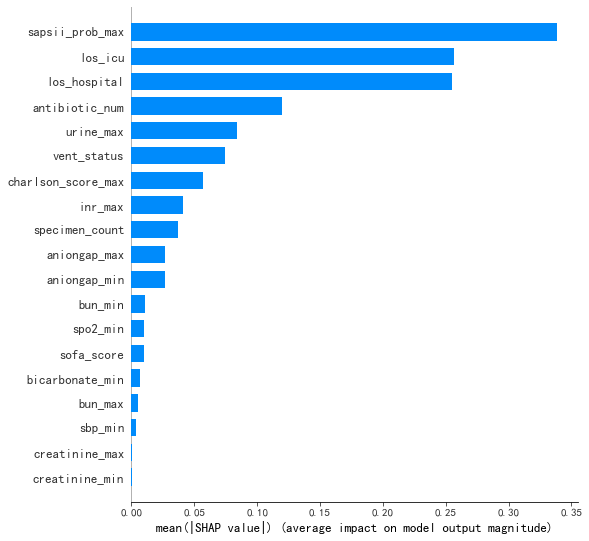

In [26]:
# fig4=plt.figure(figsize=(8,6))
%matplotlib inline
shap.summary_plot(shap_values[1], xtest, plot_type="bar")

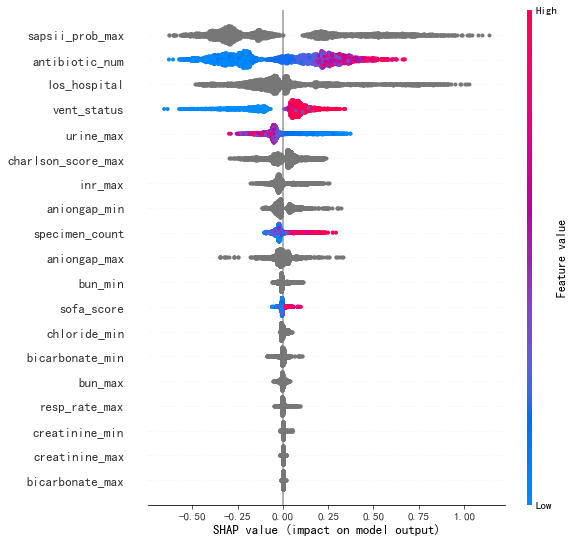

In [74]:
shap.summary_plot(shap_values[1], xtest,plot_type='dot')